# Setup for Retinal Ganglion Cell Task

This notebook takes the raw data uploaded to `Zenodo` from Ran et al.

It selects the columns that are relevant for us and joins them into a single dataframe: `results/data/setup.pkl`.

In addition, this notebooks infers the center of the image (and adds it as a column to the dataframe. Unfortunately, this information was only available in a different (shifted) coordinate system. Therefore, I post-hoc align the image center such that it is as close as possible to the center of the respective ROIs, averaged across all scan fields (I do not change the relative image positions).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
import jax.numpy as jnp
from jax import jit, vmap
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import pandas as pd
import matplotlib as mpl
from scipy.ndimage import rotate

import jaxley as jx
from jaxley.channels import HH

### How to run this

1) Install pandas version 1.5.3: `pip install pandas==1.5.3`
2) Download [data from zenodo](https://zenodo.org/records/3708064) into `jaxley_experiments/nex/rgc/data/`.
3) Download [noise stimulus from github](https://github.com/berenslab/rgc_dendrites/blob/master/data/raw/noise.h5) into `jaxley_experiments/nex/rgc/data/`.
4) Download [chirp stimulus from github](https://github.com/berenslab/rgc_dendrites/blob/master/data/raw/chirp_old.h5) into `jaxley_experiments/nex/rgc/data/`.

### Load stimulus and recordings

In [4]:
# Contains meta information regarding the ROIs, such as its location, distance to soma,
# which cell the ROI is from, and what branch (and compartment) of the cell it is from.
# But it is unclear to me how I should understand which branch is number 308 here in
# the SWC file.
# "expdate" column is the morphology index.
# "recoding_id" is the `scan field`.
data_roi = pickle.load(open('data/data_roi.pickle', 'rb'))

# Data on the centers of the ROI, the RF, and the soma and their respective distances.
data_cntr = pickle.load(open('data/data_cntr.pickle', 'rb'))

# Morphologies (essentially SWC as a pandas table).
data_morph = pickle.load(open('data/data_morph.pickle', 'rb'))

# Images of the ROIs with calcium activity. Only has 182 rows.
data_scans = pickle.load(open('data/data_scans.pickle', 'rb'))

# Extraced calcium traces in response to noise, chirp, lchirp. Also contains the
# timestamps for the stimulus and recordings.
data_raw = pickle.load(open('data/data_raw.pickle', 'rb'))

# 31 rows. Columns: cell_id, pixel_size, shape, position. No idea why this is relevant.
data_stacks_info = pickle.load(open('data/data_stacks_info.pickle', 'rb'))

# An array of shape (31988,). The chirp stimulus.
file = h5py.File("data/chirp_old.h5", 'r+')
chirp_stimulus = file["chirp"][()]

# An array of shape (1500, 15, 20). The noise stimulus over time, at 5 Hz (see paper).
# Note that recordings are at 31.25 Hz.
file = h5py.File("data/noise.h5", 'r+')
noise_stimulus = file["k"][()]


### Helper functions

In [23]:
def infer_image_center(meta_one_morph, data_scans_one_morph, data_stacks_one_morph):
    grouped_meta = meta_one_morph.groupby("recording_id")["roi_pos"].apply(list)
    grouped_meta_recoring_center = meta_one_morph.groupby("recording_id")["recording_center"].apply(list)
    grouped_scans = data_scans_one_morph.groupby("rec_id")["position"].apply(list)
    
    grouped_meta = grouped_meta.to_frame()
    grouped_meta["recording_id"] = grouped_meta.index
    
    grouped_meta_recoring_center = grouped_meta_recoring_center.to_frame()
    
    grouped_scans = grouped_scans.to_frame()
    grouped_scans["rec_id"] = grouped_scans.index
    
    scan_fields = grouped_meta.join(grouped_scans, how="inner")
    scan_fields = scan_fields.join(grouped_meta_recoring_center, how="inner")
    scale_factor = data_stacks_one_morph["pixel_size"].to_numpy()[0][0]

    desired_shifts_x = []
    desired_shifts_y = []
    
    for rec_id, scan_field in scan_fields.iterrows():
        roi_pos = np.stack(scan_field["roi_pos"])

        desired_x = np.mean(roi_pos, axis=0)[0]
        desired_y = np.mean(roi_pos, axis=0)[1]
    
        ##### Obtain the center of the camera image for each scan field #####
        pos = scan_field["recording_center"][0] * scale_factor

        recording_x = pos[0]
        recording_y = pos[1]

        desired_shifts_x.append(desired_x - recording_x)
        desired_shifts_y.append(desired_y - recording_y)

    shift_x = np.mean(desired_shifts_x)
    shift_y = np.mean(desired_shifts_y)
    
    scan_fields["image_center_x"] = np.zeros(len(scan_fields))
    scan_fields["image_center_y"] = np.zeros(len(scan_fields))
    for rec_id, scan_field in scan_fields.iterrows():
        pos = scan_field["recording_center"][0] * scale_factor
        pos[0] += shift_x
        pos[1] += shift_y
        scan_fields.loc[rec_id, "image_center_x"] = pos[0]
        scan_fields.loc[rec_id, "image_center_y"] = pos[1]

    scan_fields.drop(columns="recording_center", inplace=True)
    scan_fields.drop(columns="roi_pos", inplace=True)
    
    return scan_fields

In [24]:
def generate_roi_df(morph):
    meta_one_morph = data_roi[data_roi["expdate"] == morph]
    calcium_one_morph = data_raw[data_raw["expdate"] == morph]
    data_scans_one_morph = data_scans[data_scans["cell_id"] == morph]
    data_stacks_one_morph = data_stacks_info[data_stacks_info["cell_id"] == morph]
    data_morph_one_morph = data_morph[data_morph["expdate"] == morph]

    scan_fields = infer_image_center(meta_one_morph, data_scans_one_morph, data_stacks_one_morph)
    
    joined = meta_one_morph.join(scan_fields, how="inner", on="recording_id", rsuffix="scan_")
    joined = joined[["recording_id", "roi_id", "roi_pos", "image_center_x", "image_center_y"]]

    exploded_cols = pd.DataFrame(joined['roi_pos'].to_list(), columns=['roi_x','roi_y','roi_z'])
    exploded_cols.index = joined.index
    joined = joined.join(exploded_cols, how="inner")
    joined.drop(columns="roi_pos", inplace=True)
    joined.rename(columns={"recording_id": "rec_id"}, inplace=True)
    return joined

### Generate a unified dataframe

In [25]:
fnames = []
for (dirpath, dirnames, filenames) in os.walk("morphologies"):
    fnames.extend(filenames)

In [26]:
all_dfs = []
for morph_full in fnames:
    morph = morph_full[:-4]
    joined = generate_roi_df(morph)

    cell = jx.read_swc(f"morphologies/{morph_full}", nseg=4, max_branch_len=300.0, min_radius=1.0)

    # Add columns for calcium.
    calcium_one_morph = data_raw[data_raw["expdate"] == morph][["Tracetimes0_noise", "Traces0_raw_noise", "Triggertimes_noise", "rec_id", "roi_id"]]
    joined = joined.reset_index()
    calcium_one_morph = calcium_one_morph[1:].reset_index()
    joined = joined.join(calcium_one_morph, how="inner", rsuffix="_ca")

    joined["cell_id"] = morph
    all_dfs.append(joined)

all_dfs = pd.concat(all_dfs)
all_dfs = all_dfs.reset_index()

/Users/michaeldeistler/Documents/phd/jaxley/jaxley/utils/swc.py:32: UserWarning: Found a segment with length 0. Clipping it to 1.0
  warn("Found a segment with length 0. Clipping it to 1.0")


In [27]:
all_dfs.to_pickle("results/data/setup.pkl")

### TODO: filter out those ROIs which do not have 1500 length of Triggertime_noise

# Test whether things are working: Correlation between light and calcium

### Within a scanfield, the calcium traces correlate quite strongly

In [8]:
all_dfs = pd.read_pickle("results/data/jaxley_data.pkl")

1.0
0.30684177453018885
0.2517554798477098
0.30684177453018885
1.0
0.28174713842313726
0.2517554798477098
0.28174713842313726
1.0


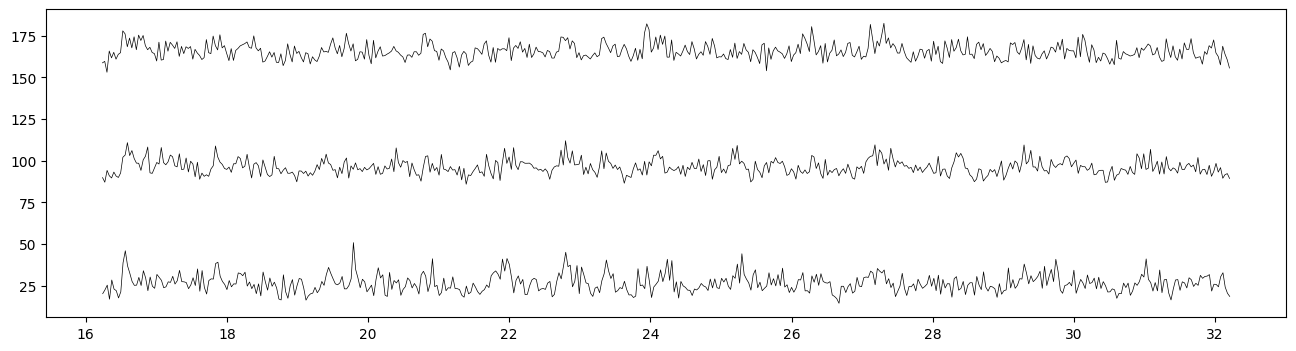

In [9]:
cell = "20161028_1"
scan_field_id = 2

start = 0
size = 500

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for roi_id in range(1, 4):
    for roi_id2 in range(1, 4):
        one_morph = all_dfs[all_dfs["cell_id"] == "20161028_1"]
        one_field = one_morph[one_morph["rec_id"] == scan_field_id]
        one_roi = one_field[one_field["roi_id"] == roi_id]

        noise_times = one_roi["Triggertimes_noise"].to_numpy()[0]
        calcium_at_roi = one_roi["Traces0_raw_noise"].to_numpy()[0]
        times_calcium = one_roi["Tracetimes0_noise"].to_numpy()[0]

        condition = times_calcium > np.min(noise_times)
        calcium_at_roi = calcium_at_roi[condition]
        times_calcium = times_calcium[condition]

        one_morph2 = all_dfs[all_dfs["cell_id"] == "20161028_1"]
        one_field2 = one_morph2[one_morph2["rec_id"] == scan_field_id]
        one_roi2 = one_field2[one_field2["roi_id"] == roi_id2]

        noise_times2 = one_roi2["Triggertimes_noise"].to_numpy()[0]
        calcium_at_roi2 = one_roi2["Traces0_raw_noise"].to_numpy()[0]
        times_calcium2 = one_roi2["Tracetimes0_noise"].to_numpy()[0]

        condition2 = times_calcium2 > np.min(noise_times2)
        calcium_at_roi2 = calcium_at_roi2[condition2]
        times_calcium2 = times_calcium2[condition2]

        # print("noise_times: ", np.min(noise_times), np.min(noise_times2))

        print(np.corrcoef(calcium_at_roi2[start:size+start], calcium_at_roi[start:size+start])[0, 1])

    ax.plot(times_calcium[start:size+start], calcium_at_roi[start:size+start] + 70*roi_id - 11000, c="k", linewidth=0.5)
plt.show()

### Between different scan fields, I also get correlation, but a bit less strong

0.32357723494525253
0.28762921873755704
0.24613581951427269
0.22548114105154354
0.2698961774699199
0.1983220849297071
0.23413384387359362
0.23346297919378278
0.23660395904100348


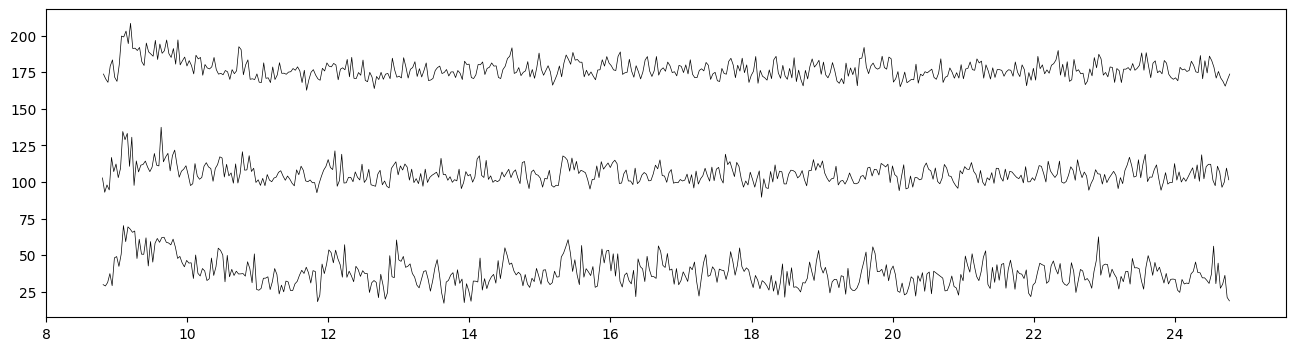

In [10]:
cell = "20161028_1"
scan_field_id1 = 1
scan_field_id2 = 2

start = 0
size = 500

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for roi_id in range(1, 4):
    for roi_id2 in range(1, 4):
        one_morph = all_dfs[all_dfs["cell_id"] == "20161028_1"]
        one_field = one_morph[one_morph["rec_id"] == scan_field_id1]
        one_roi = one_field[one_field["roi_id"] == roi_id]

        noise_times = one_roi["Triggertimes_noise"].to_numpy()[0]
        calcium_at_roi = one_roi["Traces0_raw_noise"].to_numpy()[0]
        times_calcium = one_roi["Tracetimes0_noise"].to_numpy()[0]

        condition = times_calcium > np.min(noise_times)
        calcium_at_roi = calcium_at_roi[condition]
        times_calcium = times_calcium[condition]

        one_morph2 = all_dfs[all_dfs["cell_id"] == "20161028_1"]
        one_field2 = one_morph2[one_morph2["rec_id"] == scan_field_id2]
        one_roi2 = one_field2[one_field2["roi_id"] == roi_id2]

        noise_times2 = one_roi2["Triggertimes_noise"].to_numpy()[0]
        calcium_at_roi2 = one_roi2["Traces0_raw_noise"].to_numpy()[0]
        times_calcium2 = one_roi2["Tracetimes0_noise"].to_numpy()[0]

        condition2 = times_calcium2 > np.min(noise_times2)
        calcium_at_roi2 = calcium_at_roi2[condition2]
        times_calcium2 = times_calcium2[condition2]

        # print("noise_times: ", np.min(noise_times), np.min(noise_times2))

        print(np.corrcoef(calcium_at_roi2[start:size+start], calcium_at_roi[start:size+start])[0, 1])

    ax.plot(times_calcium[start:size+start], calcium_at_roi[start:size+start] + 70*roi_id - 11000, c="k", linewidth=0.5)
plt.show()

In [936]:
print("x_coord_max: ", np.argmax(np.abs(x_marginal)), "average", np.mean(x_mesh * np.abs(x_marginal)))
print("y_coord_max: ", np.argmax(np.abs(y_marginal)), "average", np.mean(y_mesh * np.abs(y_marginal)))

x_coord_max:  9 average 0.016740125109345118
y_coord_max:  10 average 0.023281426923223176


In [908]:
print("x_coord_max: ", np.argmax(np.abs(x_marginal)), "average", np.mean(x_mesh * np.abs(x_marginal)))
print("y_coord_max: ", np.argmax(np.abs(y_marginal)), "average", np.mean(y_mesh * np.abs(y_marginal)))

x_coord_max:  9 average 0.015750192990945436
y_coord_max:  10 average 0.02385173833851867


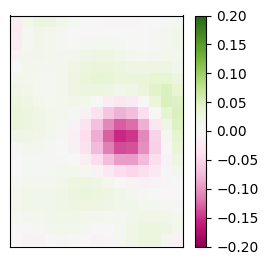

In [909]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(w_fit_image, cmap="PiYG", clim=[-0.2, 0.2])

_ = ax.set_xticks([])
_ = ax.set_yticks([])
plt.colorbar()

### Averaging and correlation test

In [258]:
pixel = 30  # um

def pixel_values_at_roi(df_roi, flip_x = False, flip_y = False):
    x_coords = np.linspace(-7 * pixel, 7 * pixel, 15) + df_roi["image_center_x"].to_numpy()
    y_coords = np.linspace(-9.5 * pixel, 9.5 * pixel, 20) + df_roi["image_center_y"].to_numpy()
    
    x_dists = (df_roi["roi_x"].to_numpy() - x_coords)**2
    y_dists = (df_roi["roi_y"].to_numpy() - y_coords)**2
    
    ind_x = np.argmin(x_dists)
    ind_y = np.argmin(y_dists)

    # Potentially flip.
    noise_stimulus_flipped = noise_stimulus
    if flip_x:
        noise_stimulus_flipped = np.flip(noise_stimulus_flipped, axis=0)
    if flip_y:
        noise_stimulus_flipped = np.flip(noise_stimulus, axis=1)

    pixel_values = noise_stimulus_flipped[ind_x-1:ind_x+2, ind_y-1:ind_y+2, :]
    
    av_noise_at_center = np.mean(pixel_values, axis=(0, 1))
    return av_noise_at_center

In [ ]:
flip_x = False
flip_y = False

for fname in fnames[:1]:
    print("=====")
    cell = fname[:-4]
    scan_field_id1 = 15
    
    one_morph = all_dfs[all_dfs["cell_id"] == cell]
    num_scan_fields = np.unique(one_morph["rec_id"])
    
    for scan_field_id1 in range(1, len(num_scan_fields)+1):
        start = 0
        size = 500
        
        one_field = one_morph[one_morph["rec_id"] == scan_field_id1]
        
        for roi_id in range(1, len(one_field)+1):
            one_roi = one_field[one_field["roi_id"] == roi_id]
                    
            noise_times = one_roi["Triggertimes_noise"].to_numpy()[0]
            calcium_at_roi = one_roi["Traces0_raw_noise"].to_numpy()[0]
            times_calcium = one_roi["Tracetimes0_noise"].to_numpy()[0]
            
            condition = times_calcium > np.min(noise_times)
            calcium_at_roi = calcium_at_roi[condition]
            times_calcium = times_calcium[condition]

            
            av_noise_at_center = pixel_values_at_roi(one_roi, flip_x=flip_x, flip_y=flip_y)
            
            noise_times_dummy = noise_times + 0.19
            av_noise_dummy = av_noise_at_center
            
            joined_times = np.concatenate([noise_times, noise_times_dummy])
            joined_stim = np.concatenate([av_noise_at_center, av_noise_at_center])
            sorting = np.argsort(joined_times)
            
            joined_times = joined_times[sorting]
            joined_stim = joined_stim[sorting]
            
            interpolated_noise = np.interp(times_calcium, joined_times, joined_stim)
            
            all_correlations = []
            for num_pad_steps in range(60):
                padded_noise = 0.5 * np.ones((num_pad_steps,))
                noise_with_padding = np.concatenate([padded_noise, interpolated_noise])
                
                correlation = np.corrcoef(calcium_at_roi[start:size+start], noise_with_padding[start:size+start])
                all_correlations.append(correlation[0, 1])
            
            time_offset = times_calcium[60] - times_calcium[0]
            offset_vec = np.linspace(0, time_offset, len(all_correlations))

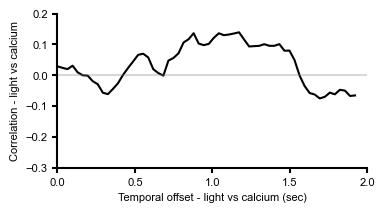

In [417]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    _ = ax.plot(offset_vec, all_correlations, c="k")
    _ = ax.axhline(0.0, alpha=0.3, c="gray")
    _ = ax.set_xlabel("Temporal offset - light vs calcium (sec)")
    _ = ax.set_ylabel("Correlation - light vs calcium")
    _ = ax.set_xlim([0, 2])
    _ = ax.set_xticks(np.linspace(0, 2, 5))
    _ = ax.set_yticks([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2])
    plt.show()